In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)
from src.data_models.caravanify import Caravanify, CaravanifyConfig 

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroDataModule

---

## Testing Caravanify

In [3]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/timeseries/csv",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
# ids_for_training = [
#     "CA_15016",
#     "CA_17462",
# ]
ids_for_training = caravan.get_all_gauge_ids()

print(f"Total number of stations: {len(ids_for_training)}")

caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()  # MultiIndex: (gauge_id, date)
static_data = caravan.get_static_attributes()  # Columns merged from enabled attributes

Total number of stations: 78


In [4]:
ts_data["date"] = pd.to_datetime(ts_data["date"])

# Now we can get the day of year using dt accessor
ts_data["julian_day"] = ts_data["date"].dt.dayofyear

# Get column names excluding specific columns
ts_columns = [
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "streamflow",
    "julian_day",
    "temperature_2m_mean",
    "total_precipitation_sum",
]

In [5]:
ts_data

,gauge_id,date,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,v_component_of_wind_10m_max,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_4_max,total_precipitation_sum,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,streamflow,julian_day
0,CA_15013,2000-01-02,130.25,15.01,-9.28,71.16,-10.18,-13.73,0.95,1.99,...,2.73,0.34,0.35,0.35,0.38,5.97,0.13,0.24,0.63,2
1,CA_15013,2000-01-03,144.62,10.59,-11.76,71.11,-8.43,-9.87,1.72,0.54,...,1.44,0.34,0.35,0.35,0.38,20.43,-0.00,0.07,0.63,3
2,CA_15013,2000-01-04,167.69,13.05,-16.00,71.25,-9.37,-11.59,-0.24,0.83,...,1.76,0.34,0.35,0.35,0.38,20.20,0.12,0.03,0.63,4
3,CA_15013,2000-01-05,176.24,23.73,-41.70,71.20,-10.44,-15.85,-0.68,2.28,...,2.72,0.34,0.35,0.35,0.38,1.24,0.37,0.15,0.63,5
4,CA_15013,2000-01-06,176.33,25.52,-48.74,71.05,-13.20,-18.98,-0.77,2.42,...,2.93,0.34,0.34,0.35,0.38,0.04,0.28,0.12,0.63,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712213,CA_17462,2024-12-27,430.68,43.61,-59.67,65.91,-20.51,-31.63,-0.25,1.13,...,1.45,0.30,0.28,0.28,0.32,0.00,0.08,0.07,NaN,362
712214,CA_17462,2024-12-28,430.68,44.42,-59.32,65.83,-20.91,-31.22,-0.27,1.21,...,1.59,0.30,0.28,0.28,0.32,0.00,0.08,0.07,NaN,363
712215,CA_17462,2024-12-29,430.68,43.91,-52.63,65.66,-20.63,-31.02,-0.32,1.60,...,1.80,0.30,0.28,0.28,0.32,0.00,0.09,0.15,NaN,364
712216,CA_17462,2024-12-30,431.09,34.71,-32.93,65.49,-15.47,-21.93,-0.02,1.11,...,1.41,0.30,0.28,0.28,0.32,0.88,0.10,0.15,NaN,365


In [6]:
whole_data = ts_columns + ["gauge_id", "date"]
ts_data = ts_data[whole_data]

# # Group by gauge_id 
# grouped = ts_data.groupby("gauge_id")

# # Plot time series for each gauge of the ts_columns of the last 5 years
# for gauge_id, group in grouped:
#     group = group.set_index("date")
#     group = group.loc["2015-01-01":"2020-12-31"]
#     group[ts_columns].plot(subplots=True, figsize=(20, 20), title=gauge_id)
#     plt.show()



In [7]:
statics_to_keep = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

static_columns = static_data.columns
static_columns = [col for col in list(static_columns) if col in statics_to_keep]

static_data = static_data[static_columns]
static_data

,gauge_id,area,cly_pc_sav,ele_mt_sav,slp_dg_sav,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,high_prec_dur,high_prec_freq,p_mean
0,CA_15013,254.786460,14.563168,2908.817796,174.240171,0.971101,0.531601,0.378615,1.139241,0.035202,2.243786
1,CA_15016,330.553623,12.462950,3332.875111,232.965619,0.430305,0.326681,0.445887,1.179641,0.025684,2.835258
2,CA_15020,310.918652,14.465533,3378.811981,256.956719,0.318642,0.265535,0.438106,1.256944,0.023598,3.604888
3,CA_15022,204.078792,12.105723,3366.325086,241.884120,0.368708,0.295262,0.442763,1.214286,0.022164,3.267226
4,CA_15025,318.622912,13.610976,3295.361905,240.016257,0.328165,0.266854,0.444063,1.240000,0.024250,3.717301
...,...,...,...,...,...,...,...,...,...,...,...
73,CA_17329,1458.923315,12.344195,3347.889488,273.271701,0.446643,0.339998,0.667605,1.169565,0.035072,3.498126
74,CA_17338,336.704776,12.361533,3253.372200,291.626302,0.446802,0.380143,0.591362,1.150442,0.033898,3.100668
75,CA_17344,1106.347332,15.307628,2584.425729,234.203248,0.711775,0.514821,0.513960,1.163569,0.040808,2.820111
76,CA_17453,1980.865238,11.630200,3761.505048,286.891636,0.332651,0.292161,0.825241,1.345745,0.032986,2.327325


# 1. Load and prepare CAMELS-CH data

In [8]:
# camels_config = CamelsCHConfig(
#     timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
#     timeseries_pattern="CAMELS_CH_obs_based_*.csv",
#     static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
#     use_climate=False,
#     use_geology=False,
#     use_glacier=False,
#     use_human_influence=False,
#     use_hydrogeology=False,
#     use_hydrology=False,
#     use_landcover=False,
#     use_soil=False,
#     use_topographic=False,
# )

In [9]:
# all_gauge_ids = get_all_gauge_ids(camels_config)

# ids_for_training = all_gauge_ids[:5]

# camels = CamelsCH(camels_config)
# camels.load_stations(ids_for_training)

In [10]:
# data = camels.get_time_series()
# data = data[
#     [
#         "gauge_id",
#         "date",
#         "discharge_spec(mm/d)",
#     ]
# ]

# data

In [11]:
# static = camels.get_static_attributes()
# sc = static.columns

# # for i in range(len(sc)):
# #     print(f"{i}: {sc[i]}")
# static_attributes = [
#     "gauge_id",
#     "area", 
#     "elev_mean",  
#     "slope_mean",  
#     "aridity",  
#     "p_seasonality",  
#     "frac_snow",  
#     "porosity",  
#     "conductivity",  
#     "p_mean",  
#     "geo_porosity",  
# ]
# static = static[static_attributes]
# static

# 2. Configure preprocessing

In [12]:
preprocessing_config = {
    "features": {
        "scale_method": "per_basin",
        "log_transform": []
    },
    "target": {
        "scale_method": "per_basin",
        "log_transform": False
    },
    "static_features": {
        "scale_method": "global"
    }
}

# 3. Create DataModule

In [13]:
output_length = 10


data_module = HydroDataModule(
    time_series_df=ts_data,
    static_df=static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_config,
    batch_size=32,
    input_length=30,
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=5,
    val_years=1,
    test_years=1,
)

# data_module.prepare_data()  # Process the data
# data_module.setup()  # Create train/val/test splits

# # Now check the processing
# print("Static features:", data_module.static_features)
# print("Static data processed:", data_module.processed_static is not None)
# print("Static scalers present:", "static" in data_module.scalers)

In [14]:
data_module.target

'streamflow'

## 4. Create model and train

In [15]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer
from src.models.evaluators import TSForecastEvaluator
from torch.optim import Adam
from torch.nn import MSELoss

# 5. Evalue and plot results

In [16]:
# model = LitLSTM(
#     input_size=len(ts_columns),
#     hidden_size=16,
#     num_layers=1,
#     output_size=output_length,
#     target=data_module.target,
# )

# model = LitEALSTM(
#     input_size_dyn=len(ts_columns),
#     input_size_stat=len(static_columns) - 1,
#     hidden_size=64,
#     output_size=output_length,
#     target=data_module.target,
# )

model = LitTSMixer(
    input_len=30,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns) - 1,
    hidden_size=64,
)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=1,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default



Quality check summary: 78 basins in original data
Quality check summary: 45 basins passed quality checks


/Users/cooper/Desktop/CAMELS-CH/src/data_models/preprocessing.py:178: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.718 -1.709 -1.699 ...  1.706  1.716  1.725]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_scaled.loc[mask, feat] = np.round(scaled_values, decimals=3)
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | TSMixer | 174 K  | train
1 | mse_criterion | MSELoss | 0      | train
--------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.700     Total estimated model params size (MB)
41        M

Created 324601 valid sequences
Created 13946 valid sequences

Data split summary:
Training: 333671 samples from 45 basins
Validation: 16425 samples from 45 basins
Testing: 16470 samples from 45 basins


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [17]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [18]:
trainer.test(model, data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    data_module, horizons=list(range(1, model.config.pred_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)


Quality check summary: 78 basins in original data
Quality check summary: 45 basins passed quality checks


/Users/cooper/Desktop/CAMELS-CH/src/data_models/preprocessing.py:178: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.718 -1.709 -1.699 ...  1.706  1.716  1.725]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_scaled.loc[mask, feat] = np.round(scaled_values, decimals=3)


Created 13984 valid sequences

Data split summary:
Training: 333671 samples from 45 basins
Validation: 16425 samples from 45 basins
Testing: 16470 samples from 45 basins


Testing: |          | 0/? [00:00<?, ?it/s]

In [19]:
overall_summary

,MSE,MAE,NSE,RMSE
horizon,,,,
1,0.056508,0.135519,0.971299,0.237714
2,0.095161,0.171773,0.951755,0.308482
3,0.126505,0.194209,0.935984,0.355675
4,0.154445,0.211509,0.921993,0.392994
5,0.183295,0.230490,0.907587,0.428129
6,0.212799,0.250738,0.892909,0.461301
7,0.239464,0.269459,0.879712,0.489351
8,0.255476,0.277928,0.871923,0.505447
9,0.283612,0.295763,0.858131,0.532552


In [20]:
basin_summary

MSE       MAE       NSE      RMSE
basin_id horizon                                        
CA_15013 1        0.225015  0.276746  0.944820  0.474357
         2        0.382583  0.361842  0.906144  0.618533
         3        0.511168  0.427381  0.874572  0.714960
         4        0.583775  0.446937  0.856753  0.764051
         5        0.667979  0.485160  0.836112  0.817300
...                    ...       ...       ...       ...
CA_17462 6        0.008764  0.054902  0.697834  0.093615
         7        0.010311  0.059710  0.646066  0.101541
         8        0.011646  0.065040  0.601960  0.107919
         9        0.012684  0.070018  0.568378  0.112624
         10       0.012824  0.069753  0.565494  0.113244

[450 rows x 4 columns]

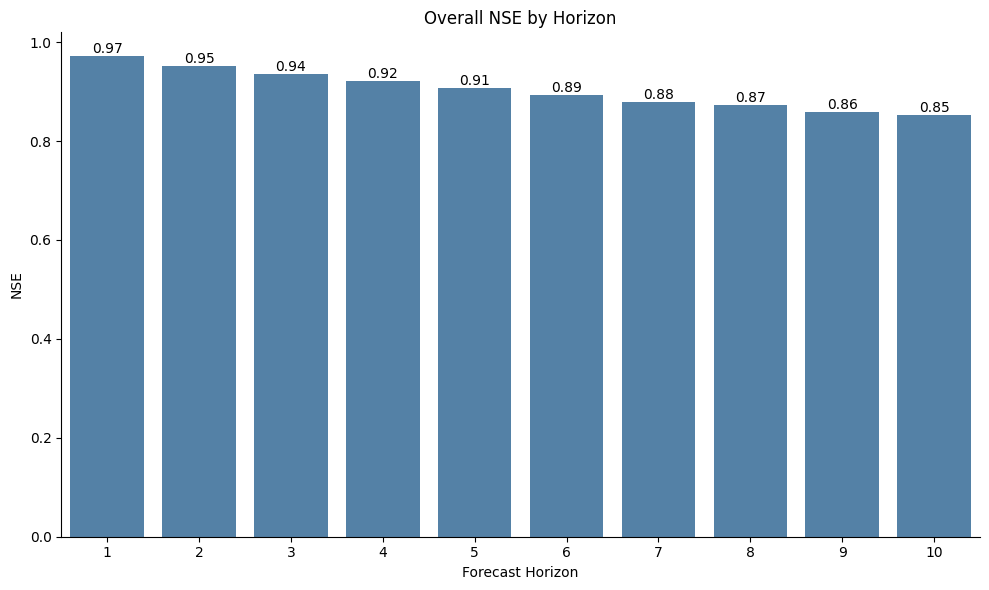

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
# plot_metric_summary(
#     basin_summary, "NSE", per_basin=True, figsize=(12, 6)
# )  